In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import pretrained_microscopy_models as pmm
import torch.utils.model_zoo as model_zoo
import warnings
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import datetime

# Suppress the PyTorch deprecation warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [17]:
image_path = 'dss_2205/image/'
data_path = 'dss_2205/hardness_table.csv'

In [18]:
# image augmentations
train_augmentations = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])

test_augmentations = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])

In [19]:
IMG_SIZE = 768   # Based on your previous code (384+384)
PATCH_SIZE = 384  # New size you want

# dataset perparation
class IM2PROPDataset(Dataset):
    """
    Tiles each 768x768 image into 4 patches of 384x384 (TL, TR, BL, BR).
    Target value is copied to all patches.
    """
    # 4 quadrants (left, top, right, bottom)
    # using this to increase dataset size

    # Generate the list of 144 boxes dynamically
    # Format: (left, top, right, bottom)
    BOXES = [
        (x, y, x + PATCH_SIZE, y + PATCH_SIZE)
        for y in range(0, IMG_SIZE, PATCH_SIZE)
        for x in range(0, IMG_SIZE, PATCH_SIZE)
    ]

    def __init__(self, csv_data, image_dir, transform=None, return_info=False):
        # Expect columns: image_id, avg_hardness, avg_hardness_round
        self.data = csv_data.reset_index(drop=True)
        self.img_dir = image_dir
        self.transform = transform
        self.return_info = return_info  # if True, also return (img_name, patch_id)

    def __len__(self):
        # 4 tiles per base image
        return len(self.data) * (IMG_SIZE // PATCH_SIZE) ** 2

    def __getitem__(self, idx):
        base_idx = idx // (IMG_SIZE // PATCH_SIZE) ** 2        # which base image
        patch_id = idx % (IMG_SIZE // PATCH_SIZE) ** 2         # which quadrant

        img_name = self.data.iloc[base_idx, 0]  # 'image_id'
        target   = self.data.iloc[base_idx, 2]  # 'avg_hardness_round'
        img_path = os.path.join(self.img_dir, f"{img_name}.png")

        image = Image.open(img_path).convert("RGB")
        tile  = image.crop(self.BOXES[patch_id])  # 384x384

        if self.transform:
            tile = self.transform(tile)

        target = torch.tensor(target, dtype=torch.float32)

        if self.return_info:
            return tile, target, (img_name, patch_id)
        return tile, target

In [20]:
df = pd.read_csv(data_path)

random_state = random.randint(0, 10000)

train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=random_state)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=random_state)

train_dataset = IM2PROPDataset(train_df, image_dir=image_path, transform=train_augmentations)
val_dataset = IM2PROPDataset(val_df, image_dir=image_path, transform=test_augmentations)
test_dataset = IM2PROPDataset(test_df, image_dir=image_path, transform=test_augmentations)

print(f"Train images: {len(train_dataset)}")
print(f"Val images  : {len(val_dataset)}")
print(f"Test images : {len(test_dataset)}")
print(f"Total       : {len(train_dataset)+len(val_dataset)+len(test_dataset)}")

Train images: 152
Val images  : 40
Test images : 48
Total       : 240


In [21]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=False)

In [22]:
# --- 1. Define the Custom Regression Head (Decoder) ---
class RegressionHead(nn.Module):
    """
    The decoder part of the model, which performs aggregation and
    final dimensionality reduction from the 2048 feature channels to a single scalar.
    """
    def __init__(self, final_output_dim=1):
        super().__init__()
        
        # Spatial Aggregation: Global Average Pooling (GAP)
        # Input: [B, 2048, H, W] -> Output: [B, 2048, 1, 1]
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Channel-wise Dimensionality Reduction: Linear Layers
        self.regressor = nn.Sequential(
            # Input size is 2048 (from GAP)
            nn.Linear(2048, 1024), 
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(1024, 512), 
            nn.BatchNorm1d(512),
            nn.ReLU(),
            # nn.Dropout(0.5),

            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, final_output_dim)  # Final output layer
        )

    def forward(self, x):
        # x shape: [B, 2048, H, W]
        x = self.avgpool(x)       # Shape: [B, 2048, 1, 1]
        x = torch.flatten(x, 1)   # Shape: [B, 2048] (The latent feature vector)
        output = self.regressor(x)
        
        return output

# --- 2. Define the Complete Model Wrapper ---
class MicroNetRegressor(nn.Module):
    """
    Combines the pre-trained ResNet encoder features with the new Regression Head.
    """
    def __init__(self, pre_trained_base_model):
        super().__init__()
        
        # --- ENCODER (The pre-trained feature extractor) ---
        # We explicitly assemble the layers that constitute the ResNet feature backbone.
        # This excludes the original 'avgpool' and 'fc' classification layers.
        self.encoder_features = nn.Sequential(
            pre_trained_base_model.conv1, 
            pre_trained_base_model.bn1, 
            pre_trained_base_model.relu, 
            pre_trained_base_model.maxpool, 
            pre_trained_base_model.layer1, 
            pre_trained_base_model.layer2, 
            pre_trained_base_model.layer3, 
            pre_trained_base_model.layer4
        )
        
        # --- DECODER / REGRESSION HEAD (The new, trainable part) ---
        self.regression_head = RegressionHead(final_output_dim=1)

    def forward(self, x):
        # 1. Pass input through the pre-trained encoder
        x = self.encoder_features(x)  # Output is the deep feature map: [B, 2048, H, W]
        
        # 2. Pass feature map through the custom head for regression
        output = self.regression_head(x) # Output is the scalar prediction: [B, 1]
        
        return output
    
# --- 3. Model Initialization and Loading ---

# Configuration
encoder_name = 'resnet50'
weights_source = 'micronet'

print(f"Loading {encoder_name} architecture...")
# Initialize the base PyTorch ResNet-50 model (un-initialized, as we load custom weights later)
# Using weights=None to comply with the new PyTorch API
base_model = torch.hub.load('pytorch/vision:v0.10.0', encoder_name, weights=None)

# Get the URL for the MicroNet pre-trained weights
url = pmm.util.get_pretrained_microscopynet_url(encoder=encoder_name, encoder_weights=weights_source)

print(f"Loading MicroNet weights from: {url}")
# Load the MicroNet state dictionary into the ResNet-50 model
base_model.load_state_dict(model_zoo.load_url(url))

# 4. Instantiate the Final Regression Model
model_regressor = MicroNetRegressor(pre_trained_base_model=base_model)
model_regressor.eval() # Set model to evaluation mode (important for BN layers)
model_regressor = model_regressor.to(device)

# --- 5. Optional: Freeze the Encoder Layers ---
# Freeze all encoder weights to only train the new regression head initially
for name, param in model_regressor.named_parameters():
    if name.startswith('encoder_features'):
        param.requires_grad = False
    
# Check which parameters are trainable
total_params = sum(p.numel() for p in model_regressor.parameters())
trainable_params = sum(p.numel() for p in model_regressor.parameters() if p.requires_grad)

print("\n--- Model Summary ---")
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters (Regression Head): {trainable_params:,}")
print(f"Encoder Layers Frozen: {total_params - trainable_params:,}")

Loading resnet50 architecture...
Loading MicroNet weights from: https://nasa-public-data.s3.amazonaws.com/microscopy_segmentation_models/resnet50_pretrained_microscopynet_v1.1.pth.tar


Using cache found in /home/jay/.cache/torch/hub/pytorch_vision_v0.10.0



--- Model Summary ---
Total Parameters: 26,200,129
Trainable Parameters (Regression Head): 2,692,097
Encoder Layers Frozen: 23,508,032


In [23]:
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_regressor.parameters()), lr=1e-3)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # optional

In [24]:
# --- 3. Training Loop ---
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    
    for images, targets in tqdm(dataloader, desc="Training", leave=False):
        images, targets = images.to(device), targets.to(device).unsqueeze(1)  # [B, 1]
        
        optimizer.zero_grad()
        outputs = model(images)              # forward pass -> [B, 1]
        loss = criterion(outputs, targets)   # MSE loss
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    preds, trues = [], []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Validation", leave=False):
            images, targets = images.to(device), targets.to(device).unsqueeze(1)
            outputs = model(images)
            
            loss = criterion(outputs, targets)
            running_loss += loss.item() * images.size(0)
            
            preds.append(outputs.cpu().numpy())
            trues.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    preds_scaled = np.concatenate(preds).squeeze()
    trues_scaled = np.concatenate(trues).squeeze()

    mse = np.mean((preds_scaled - trues_scaled) ** 2)
    mae = np.mean(np.abs(preds_scaled - trues_scaled))
    rmse = np.sqrt(mse)

    return epoch_loss, mae, mse, rmse


Epoch [1/50]


Train Loss: 1.5675 | Val Loss: 1.3033 | Val MAE: 1.8033 | Val MSE: 3.3071 | Val RMSE: 1.8186
✅ Saved new best model

Epoch [2/50]


Train Loss: 0.4920 | Val Loss: 0.6218 | Val MAE: 1.0936 | Val MSE: 1.3226 | Val RMSE: 1.1500
✅ Saved new best model

Epoch [3/50]


Train Loss: 0.0924 | Val Loss: 0.0136 | Val MAE: 0.1273 | Val MSE: 0.0272 | Val RMSE: 0.1648
✅ Saved new best model

Epoch [4/50]


Train Loss: 0.0548 | Val Loss: 0.0887 | Val MAE: 0.3642 | Val MSE: 0.1774 | Val RMSE: 0.4211

Epoch [5/50]


Train Loss: 0.0274 | Val Loss: 0.0424 | Val MAE: 0.2497 | Val MSE: 0.0848 | Val RMSE: 0.2912

Epoch [6/50]


Train Loss: 0.0274 | Val Loss: 0.0210 | Val MAE: 0.1834 | Val MSE: 0.0421 | Val RMSE: 0.2051

Epoch [7/50]


Train Loss: 0.0177 | Val Loss: 0.0145 | Val MAE: 0.1465 | Val MSE: 0.0291 | Val RMSE: 0.1705

Epoch [8/50]


Train Loss: 0.0135 | Val Loss: 0.0180 | Val MAE: 0.1688 | Val MSE: 0.0360 | Val RMSE: 0.1898

Epoch [9/50]


Train Loss: 0.0146 | Val Loss: 0.0193 | Val MAE: 0.1373 | Val MSE: 0.0385 | Val RMSE: 0.1963

Epoch [10/50]


Train Loss: 0.0156 | Val Loss: 0.0281 | Val MAE: 0.1670 | Val MSE: 0.0562 | Val RMSE: 0.2371

Epoch [11/50]


Train Loss: 0.0177 | Val Loss: 0.0243 | Val MAE: 0.1999 | Val MSE: 0.0486 | Val RMSE: 0.2205

Epoch [12/50]


Train Loss: 0.0225 | Val Loss: 0.0175 | Val MAE: 0.1675 | Val MSE: 0.0350 | Val RMSE: 0.1872

Epoch [13/50]


Train Loss: 0.0213 | Val Loss: 0.0131 | Val MAE: 0.1372 | Val MSE: 0.0261 | Val RMSE: 0.1616
✅ Saved new best model

Epoch [14/50]


Train Loss: 0.0176 | Val Loss: 0.0390 | Val MAE: 0.2621 | Val MSE: 0.0780 | Val RMSE: 0.2792

Epoch [15/50]


Train Loss: 0.0123 | Val Loss: 0.0087 | Val MAE: 0.1158 | Val MSE: 0.0174 | Val RMSE: 0.1318
✅ Saved new best model

Epoch [16/50]


Train Loss: 0.0122 | Val Loss: 0.0153 | Val MAE: 0.1569 | Val MSE: 0.0307 | Val RMSE: 0.1751

Epoch [17/50]


Train Loss: 0.0190 | Val Loss: 0.0307 | Val MAE: 0.2030 | Val MSE: 0.0614 | Val RMSE: 0.2479

Epoch [18/50]


Train Loss: 0.0152 | Val Loss: 0.0325 | Val MAE: 0.2288 | Val MSE: 0.0651 | Val RMSE: 0.2551

Epoch [19/50]


Train Loss: 0.0167 | Val Loss: 0.0079 | Val MAE: 0.0998 | Val MSE: 0.0158 | Val RMSE: 0.1256
✅ Saved new best model

Epoch [20/50]


Train Loss: 0.0141 | Val Loss: 0.0061 | Val MAE: 0.0843 | Val MSE: 0.0123 | Val RMSE: 0.1108
✅ Saved new best model

Epoch [21/50]


Train Loss: 0.0118 | Val Loss: 0.0167 | Val MAE: 0.1576 | Val MSE: 0.0334 | Val RMSE: 0.1826

Epoch [22/50]


Train Loss: 0.0120 | Val Loss: 0.0494 | Val MAE: 0.1711 | Val MSE: 0.1078 | Val RMSE: 0.3283

Epoch [23/50]


Train Loss: 0.0119 | Val Loss: 0.0079 | Val MAE: 0.0945 | Val MSE: 0.0157 | Val RMSE: 0.1253

Epoch [24/50]


Train Loss: 0.0121 | Val Loss: 0.0062 | Val MAE: 0.0971 | Val MSE: 0.0124 | Val RMSE: 0.1113

Epoch [25/50]


Train Loss: 0.0110 | Val Loss: 0.0135 | Val MAE: 0.1391 | Val MSE: 0.0270 | Val RMSE: 0.1645

Epoch [26/50]


Train Loss: 0.0217 | Val Loss: 0.0182 | Val MAE: 0.1644 | Val MSE: 0.0364 | Val RMSE: 0.1909

Epoch [27/50]


Train Loss: 0.0126 | Val Loss: 0.0145 | Val MAE: 0.1588 | Val MSE: 0.0290 | Val RMSE: 0.1704

Epoch [28/50]


Train Loss: 0.0137 | Val Loss: 0.0184 | Val MAE: 0.1789 | Val MSE: 0.0367 | Val RMSE: 0.1917

Epoch [29/50]


Train Loss: 0.0098 | Val Loss: 0.0226 | Val MAE: 0.1914 | Val MSE: 0.0453 | Val RMSE: 0.2128

Epoch [30/50]


Train Loss: 0.0142 | Val Loss: 0.0118 | Val MAE: 0.1174 | Val MSE: 0.0235 | Val RMSE: 0.1535

Epoch [31/50]


Train Loss: 0.0125 | Val Loss: 0.0183 | Val MAE: 0.1523 | Val MSE: 0.0367 | Val RMSE: 0.1916

Epoch [32/50]


Train Loss: 0.0115 | Val Loss: 0.0175 | Val MAE: 0.1548 | Val MSE: 0.0350 | Val RMSE: 0.1870

Epoch [33/50]


Train Loss: 0.0097 | Val Loss: 0.0046 | Val MAE: 0.0715 | Val MSE: 0.0091 | Val RMSE: 0.0955
✅ Saved new best model

Epoch [34/50]


Train Loss: 0.0105 | Val Loss: 0.0124 | Val MAE: 0.1292 | Val MSE: 0.0248 | Val RMSE: 0.1575

Epoch [35/50]


Train Loss: 0.0094 | Val Loss: 0.0208 | Val MAE: 0.1765 | Val MSE: 0.0416 | Val RMSE: 0.2038

Epoch [36/50]


Train Loss: 0.0108 | Val Loss: 0.0119 | Val MAE: 0.1172 | Val MSE: 0.0239 | Val RMSE: 0.1546

Epoch [37/50]


Train Loss: 0.0106 | Val Loss: 0.0112 | Val MAE: 0.1337 | Val MSE: 0.0223 | Val RMSE: 0.1495

Epoch [38/50]


Train Loss: 0.0137 | Val Loss: 0.0173 | Val MAE: 0.1630 | Val MSE: 0.0347 | Val RMSE: 0.1862

Epoch [39/50]


Train Loss: 0.0064 | Val Loss: 0.0145 | Val MAE: 0.1502 | Val MSE: 0.0291 | Val RMSE: 0.1706

Epoch [40/50]


Train Loss: 0.0060 | Val Loss: 0.0053 | Val MAE: 0.0672 | Val MSE: 0.0105 | Val RMSE: 0.1027

Epoch [41/50]


Train Loss: 0.0051 | Val Loss: 0.0105 | Val MAE: 0.1213 | Val MSE: 0.0210 | Val RMSE: 0.1450

Epoch [42/50]


Train Loss: 0.0081 | Val Loss: 0.0143 | Val MAE: 0.1553 | Val MSE: 0.0285 | Val RMSE: 0.1688

Epoch [43/50]


Train Loss: 0.0111 | Val Loss: 0.0164 | Val MAE: 0.1676 | Val MSE: 0.0327 | Val RMSE: 0.1809

Epoch [44/50]


Train Loss: 0.0093 | Val Loss: 0.0117 | Val MAE: 0.1267 | Val MSE: 0.0234 | Val RMSE: 0.1531

Epoch [45/50]


Train Loss: 0.0108 | Val Loss: 0.0115 | Val MAE: 0.1333 | Val MSE: 0.0230 | Val RMSE: 0.1517

Epoch [46/50]


Train Loss: 0.0144 | Val Loss: 0.0206 | Val MAE: 0.1842 | Val MSE: 0.0411 | Val RMSE: 0.2028

Epoch [47/50]


Train Loss: 0.0091 | Val Loss: 0.0130 | Val MAE: 0.1372 | Val MSE: 0.0261 | Val RMSE: 0.1615

Epoch [48/50]


Train Loss: 0.0078 | Val Loss: 0.0084 | Val MAE: 0.1180 | Val MSE: 0.0168 | Val RMSE: 0.1297

Epoch [49/50]


Train Loss: 0.0075 | Val Loss: 0.0066 | Val MAE: 0.1021 | Val MSE: 0.0131 | Val RMSE: 0.1147

Epoch [50/50]


Train Loss: 0.0072 | Val Loss: 0.0223 | Val MAE: 0.1713 | Val MSE: 0.0446 | Val RMSE: 0.2111

Training complete!


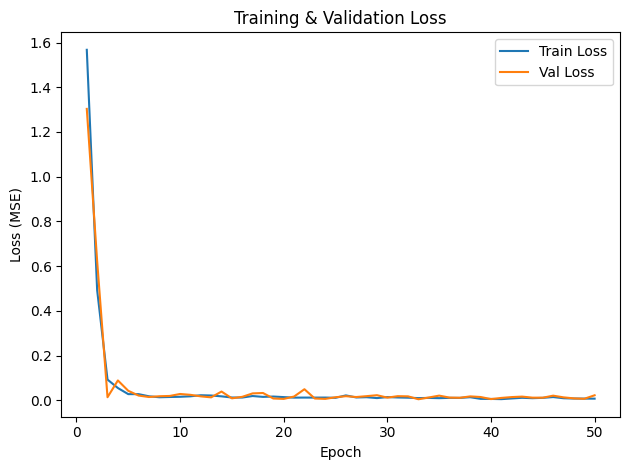

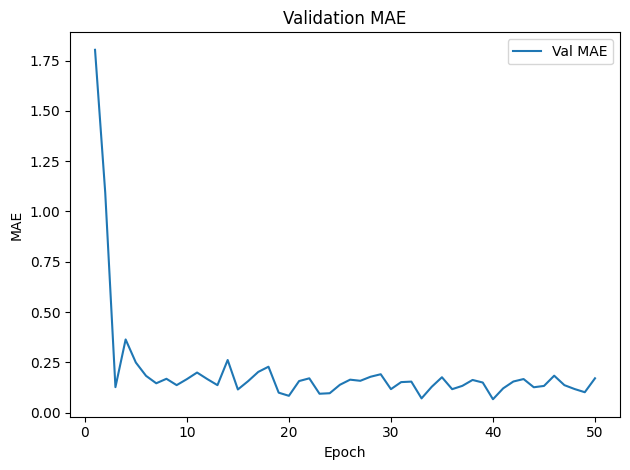

Saved plots: loss_curves.png, val_mae_curve.png


In [25]:
num_epochs = 50
best_val_loss = float('inf')
datetime_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
os.makedirs(f"runs/run_{datetime_str}", exist_ok=True)

# histories
hist_train_loss = []
hist_val_loss = []
hist_val_mae  = []

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    
    train_loss = train_one_epoch(model_regressor, train_loader, optimizer, criterion, device)
    val_loss, val_mae, val_mse, rmse = validate_one_epoch(model_regressor, val_loader, criterion, device)
    
    # Step the scheduler
    # If you're using StepLR / CosineAnnealingLR:
    # scheduler.step()
    # If you're using ReduceLROnPlateau, use this instead:
    # scheduler.step(val_loss)
    
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val MAE: {val_mae:.4f} | Val MSE: {val_mse:.4f} | Val RMSE: {rmse:.4f}")

    # record history
    hist_train_loss.append(train_loss)
    hist_val_loss.append(val_loss)
    hist_val_mae.append(val_mae)
    
    # save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_regressor.state_dict(), f"runs/run_{datetime_str}/best_regression_model.pt")
        print("✅ Saved new best model")

print("\nTraining complete!")

# ---- Plot curves ----
# Loss curves
plt.figure()
plt.plot(range(1, num_epochs+1), hist_train_loss, label='Train Loss')
plt.plot(range(1, num_epochs+1), hist_val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training & Validation Loss')
plt.legend()
plt.tight_layout()
plt.savefig(f'runs/run_{datetime_str}/loss_curves.png', dpi=200)
plt.show()

# (Optional) MAE curve
plt.figure()
plt.plot(range(1, num_epochs+1), hist_val_mae, label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Validation MAE')
plt.legend()
plt.tight_layout()
plt.savefig(f'runs/run_{datetime_str}/val_mae_curve.png', dpi=200)
plt.show()

print("Saved plots: loss_curves.png, val_mae_curve.png")


Testing: 100%|██████████| 4/4 [00:00<00:00,  9.25it/s]



--- Test Results ---
MSE : 0.0078
MAE : 0.0699
RMSE  : 0.0883


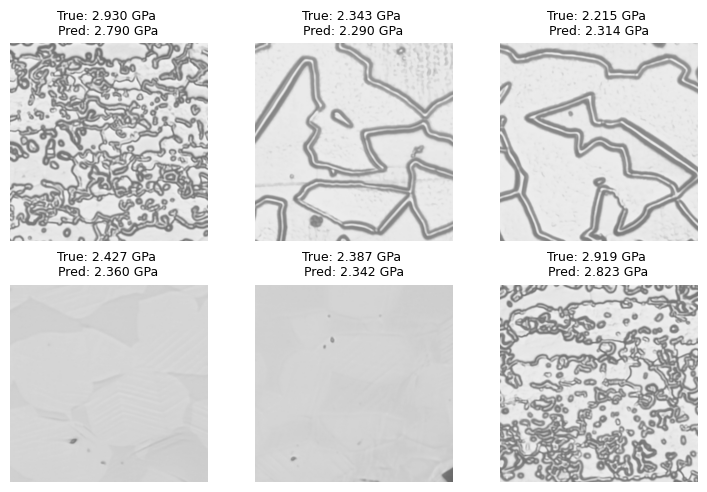

In [45]:
# Load model
model_regressor.load_state_dict(torch.load(f"runs/run_{datetime_str}/best_regression_model.pt", map_location=device))
model_regressor.to(device)
model_regressor.eval()  # VERY IMPORTANT for inference

def test_model(model, dataloader, device):
    model.eval()
    preds, trues, imgs = [], [], []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Testing"):
            images, targets = images.to(device), targets.to(device).unsqueeze(1)
            outputs = model(images)

            preds.append(outputs.cpu().numpy())
            trues.append(targets.cpu().numpy())
            imgs.append(images.cpu().numpy())  # save image batch

    preds_scaled = np.concatenate(preds).squeeze()
    trues_scaled = np.concatenate(trues).squeeze()
    imgs_np = np.concatenate(imgs)

    mse = np.mean((preds_scaled - trues_scaled) ** 2)
    mae = np.mean(np.abs(preds_scaled - trues_scaled))
    rmse = np.sqrt(mse)

    print("\n--- Test Results ---")
    print(f"MSE : {mse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE  : {rmse:.4f}")

    return preds_scaled, trues_scaled, imgs_np

def show_predictions(imgs, trues, preds, num_samples=10, max_per_row=10):

    # ---- Randomly choose sample indices ----
    idxs = np.random.choice(len(imgs), num_samples, replace=False)

    # ---- Compute rows and columns ----
    rows = (num_samples + max_per_row - 1) // max_per_row   # ceil division
    cols = min(num_samples, max_per_row)

    plt.figure(figsize=(cols * 2.5, rows * 2.5))

    for n, i in enumerate(idxs):

        plt.subplot(rows, cols, n + 1)
        plt.imshow(np.transpose(imgs[i], (1, 2, 0)))
        plt.title(f"True: {trues[i]:.3f} GPa \nPred: {preds[i]:.3f} GPa", fontsize=9)
        plt.axis("off")
    
    plt.savefig(f'runs/run_{datetime_str}/test_result.png', dpi=200)
    plt.tight_layout()
    plt.show()

# Run test
preds, trues, imgs = test_model(model_regressor, test_loader, device)
show_predictions(imgs, trues, preds, num_samples=6, max_per_row=3)


In [27]:
# # ============================================
# # --- Load model ---
# # ============================================
# model_regressor.load_state_dict(
#     torch.load(f"runs/run_{datetime_str}/best_regression_model.pt", map_location=device)
# )
# model_regressor.to(device)
# model_regressor.eval()  # VERY IMPORTANT for inference


# # ============================================
# # --- Grad-CAM helper ---
# # ============================================
# gradcam = GradCAM(model_regressor)  # from your model code


# def show_gradcam_overlay(img_tensor, cam_tensor, alpha=0.45):
#     """
#     img_tensor: [3,H,W], values in [0,1]
#     cam_tensor: [1,H,W], values in [0,1]
#     """
#     import numpy as np
#     import matplotlib.pyplot as plt

#     img = img_tensor.detach().cpu().numpy().transpose(1, 2, 0)
#     cam = cam_tensor.detach().cpu().numpy()[0]

#     cmap = plt.get_cmap("jet")
#     cam_color = cmap(cam)[:, :, :3]
#     overlay = np.clip(alpha * cam_color + (1 - alpha) * img, 0, 1)
#     return img, cam, overlay


# # ============================================
# # --- Test function with Grad-CAM visualization ---
# # ============================================
# def test_model(model, dataloader, device, show_num=12, save_dir=None):
#     model.eval()
#     preds, trues, images_all = [], [], []

#     os.makedirs(save_dir, exist_ok=True) if save_dir else None

#     with torch.no_grad():
#         for images, targets in tqdm(dataloader, desc="Testing"):
#             images, targets = images.to(device), targets.to(device).unsqueeze(1)
#             outputs = model(images)

#             preds.append(outputs.cpu().numpy())
#             trues.append(targets.cpu().numpy())
#             images_all.append(images.cpu().numpy())

#     preds_scaled = np.concatenate(preds).squeeze()
#     trues_scaled = np.concatenate(trues).squeeze()
#     imgs_np = np.concatenate(images_all)

#     mse = np.mean((preds_scaled - trues_scaled) ** 2)
#     mae = np.mean(np.abs(preds_scaled - trues_scaled))
#     rmse = np.sqrt(mse)

#     print("\n--- Test Results ---")
#     print(f"MSE  : {mse:.4f}")
#     print(f"MAE  : {mae:.4f}")
#     print(f"RMSE : {rmse:.4f}")

#     # --- Show Grad-CAM for first few samples ---
#     model.eval()
#     x = torch.tensor(imgs_np[:show_num]).to(device)
#     cams = gradcam(x, up_to_size=x.shape[-2:])  # [B,1,H,W]

#     # --- Plot results in a clean grid (3 columns) ---
#     num_show = min(show_num, x.shape[0])
#     ncols = 3
#     nrows = int(np.ceil(num_show / ncols))

#     plt.figure(figsize=(12, 4 * nrows))

#     for i in range(num_show):
#         img, cam, overlay = show_gradcam_overlay(x[i].cpu(), cams[i].cpu())

#         # column 1: original
#         plt.subplot(nrows, ncols, i * ncols % (ncols * nrows) + 1)
#         plt.imshow(img)
#         plt.axis("off")
#         plt.title(f"True:{trues_scaled[i]:.2f}\nPred:{preds_scaled[i]:.2f}")

#         # column 2: heatmap
#         plt.subplot(nrows, ncols, i * ncols % (ncols * nrows) + 2)
#         plt.imshow(cam, cmap="jet")
#         plt.axis("off")
#         plt.title("Grad-CAM")

#         # column 3: overlay
#         plt.subplot(nrows, ncols, i * ncols % (ncols * nrows) + 3)
#         plt.imshow(overlay)
#         plt.axis("off")
#         plt.title("Overlay")

#         # --- Save overlays if requested ---
#         if save_dir:
#             plt.imsave(f"{save_dir}/sample_{i}_overlay.png", overlay)

#     plt.tight_layout()
#     plt.show()

#     return preds_scaled, trues_scaled, imgs_np


# # ============================================
# # --- Run test ---
# # ============================================
# preds, trues, imgs = test_model(
#     model_regressor,
#     test_loader,
#     device,
#     show_num=15,                        # number of Grad-CAM samples to show
#     save_dir=f"runs/run_{datetime_str}/gradcam_overlays"  # optional save folder
# )

# gradcam.remove()  # cleanup hooks


In [28]:
# A. Scale mismatch?
imgs, y = next(iter(train_loader))
with torch.no_grad():
    p = model_regressor(imgs.to(device)).cpu().squeeze()
print("targets range:", y.min().item(), y.max().item())   
print("preds   range:", p.min().item(), p.max().item())    # should be similar scale


targets range: 2.2219998836517334 2.9170000553131104
preds   range: 2.25807523727417 2.828045606613159


In [39]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math
from torchvision import transforms

def generate_sliding_window_heatmap(
    model, 
    image_path, 
    crop_size=(64, 64),      # The size of the window sliding over the image
    stride=32,               # Step size (smaller = denser heatmap)
    model_input_size=(384, 384), # The size the model EXPECTS (resizes crop to this)
    device='cpu', 
    transform=None
):
    """
    Slides a window over the image, resizes the crop to match model input, and predicts.
    """
    model.eval()
    
    # 1. Load Image
    img = Image.open(image_path).convert("RGB")
    orig_w, orig_h = img.size
    crop_w, crop_h = crop_size
    
    # 2. Padding Logic (Ensure we can scan the edges)
    # We pad so that the sliding window can center or at least reach the edge pixels
    if orig_w < crop_w or orig_h < crop_h:
        cols = 1
        rows = 1
        target_w = max(orig_w, crop_w)
        target_h = max(orig_h, crop_h)
    else:
        # Calculate steps
        cols = math.ceil((orig_w - crop_w) / stride) + 1
        rows = math.ceil((orig_h - crop_h) / stride) + 1
        target_w = (cols - 1) * stride + crop_w
        target_h = (rows - 1) * stride + crop_h

    padded_img = Image.new("RGB", (target_w, target_h), (0, 0, 0))
    padded_img.paste(img, (0, 0))
    
    print(f"Original: {orig_w}x{orig_h} | Crop: {crop_size} | Stride: {stride}")
    print(f"Model Input: {model_input_size} (Resizing crops to this)")
    print(f"Heatmap Grid: {rows}x{cols}")

    heatmap = np.zeros((rows, cols))
    
    # Define resizing transform if crop dimension != model dimension
    # We use Bicubic for the resizing of the input image itself as well for better quality
    resize_transform = transforms.Resize(model_input_size, interpolation=transforms.InterpolationMode.BICUBIC)
    to_tensor = transforms.ToTensor()

    with torch.no_grad():
        for r in range(rows):
            for c in range(cols):
                # Calculate window coordinates
                left = c * stride
                top = r * stride
                right = left + crop_w
                bottom = top + crop_h
                
                # 1. Cut the small window (e.g. 64x64)
                patch = padded_img.crop((left, top, right, bottom))
                
                # 2. Resize it to what model expects (e.g. 384x384)
                # If you have specific test_augmentations, use them here instead
                if transform:
                    patch_tensor = transform(patch)
                else:
                    # Resize -> ToTensor
                    patch_resized = resize_transform(patch)
                    patch_tensor = to_tensor(patch_resized)
                
                # 3. Predict
                input_tensor = patch_tensor.unsqueeze(0).to(device)
                pred = model(input_tensor).item()
                
                heatmap[r, c] = pred
                
    return heatmap, padded_img

def plot_heatmap_overlay(heatmap, original_image, alpha=0.6, cmap='jet'):
    """
    Plots the original image side-by-side with the heatmap overlay using BICUBIC interpolation.
    """
    if heatmap is None:
        return

    w, h = original_image.size
    vmin, vmax = np.min(heatmap), np.max(heatmap)
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    
    # Original Image
    ax[0].imshow(original_image)
    ax[0].set_title(f"Original Image ({w}x{h})")
    ax[0].axis('off')
    
    # Heatmap Overlay
    ax[1].imshow(original_image)
    
    # CHANGE: interpolation='bicubic'
    im = ax[1].imshow(heatmap, cmap=cmap, alpha=alpha, extent=[0, w, h, 0], interpolation='bicubic')
    
    ax[1].set_title(f"Prediction Heatmap\nMin: {vmin:.2f} | Max: {vmax:.2f}")
    ax[1].axis('off')
    
    cbar = plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)
    cbar.set_label('Predicted Value')
    
    plt.tight_layout()
    plt.show()

def save_heatmap_only(heatmap, original_image, save_path, alpha=0.6, cmap='jet'):
    """
    Generates and saves ONLY the heatmap overlay with the scalebar (no side-by-side).
    """
    w, h = original_image.size
    vmin, vmax = np.min(heatmap), np.max(heatmap)
    
    # Create a single figure
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Background image
    ax.imshow(original_image)
    
    # Overlay
    im = ax.imshow(heatmap, cmap=cmap, alpha=alpha, extent=[0, w, h, 0], interpolation='bicubic')
    ax.axis('off') # Hide axes ticks

    ax.set_title(f"Prediction Heatmap\nMin: {vmin:.2f} GPa | Max: {vmax:.2f} GPa")
    ax.axis('off')
    
    # Scalebar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Predicted Value (GPa)')
    
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()
    print(f"Saved heatmap only to: {save_path}")

Original: 1920x1080 | Crop: (384, 384) | Stride: 8
Model Input: (384, 384) (Resizing crops to this)
Heatmap Grid: 88x193


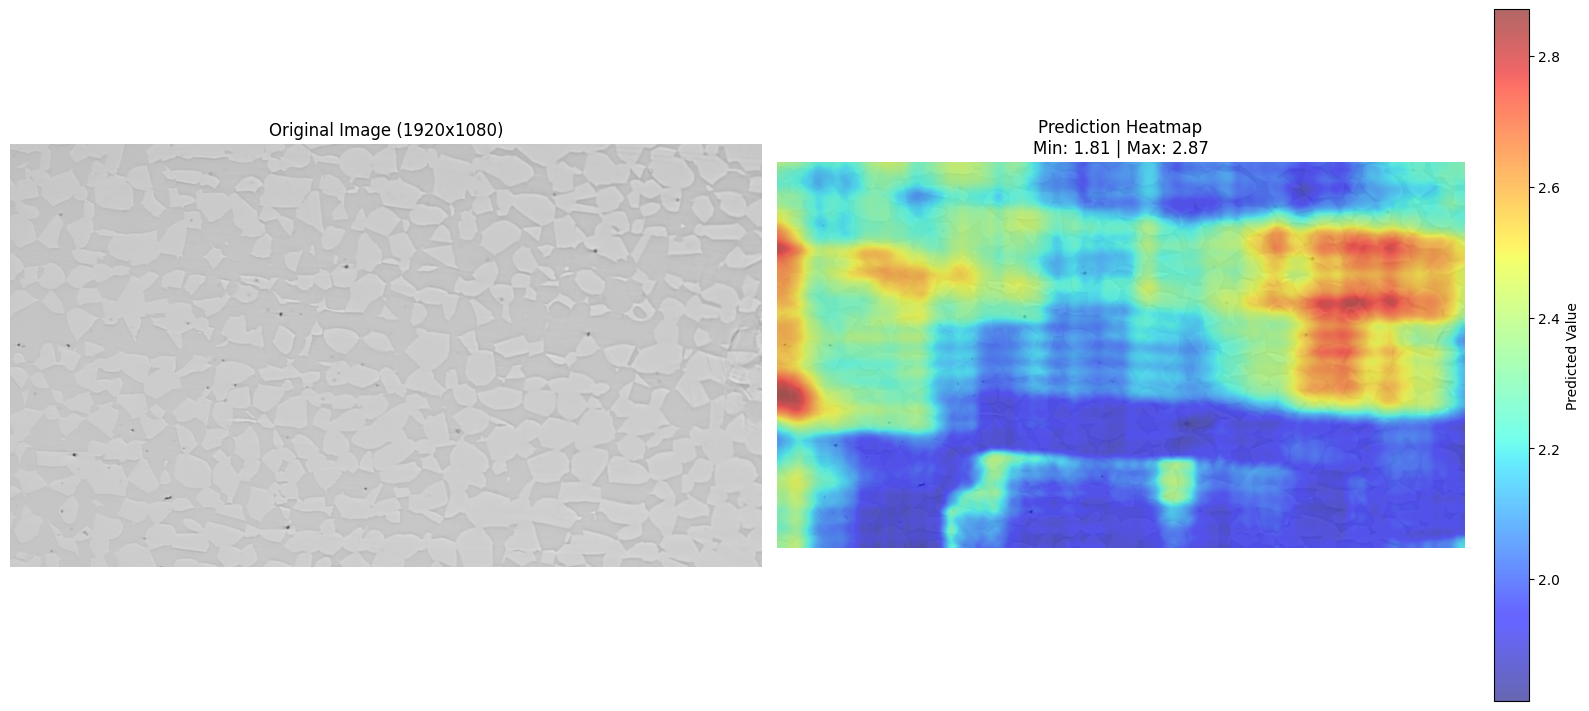

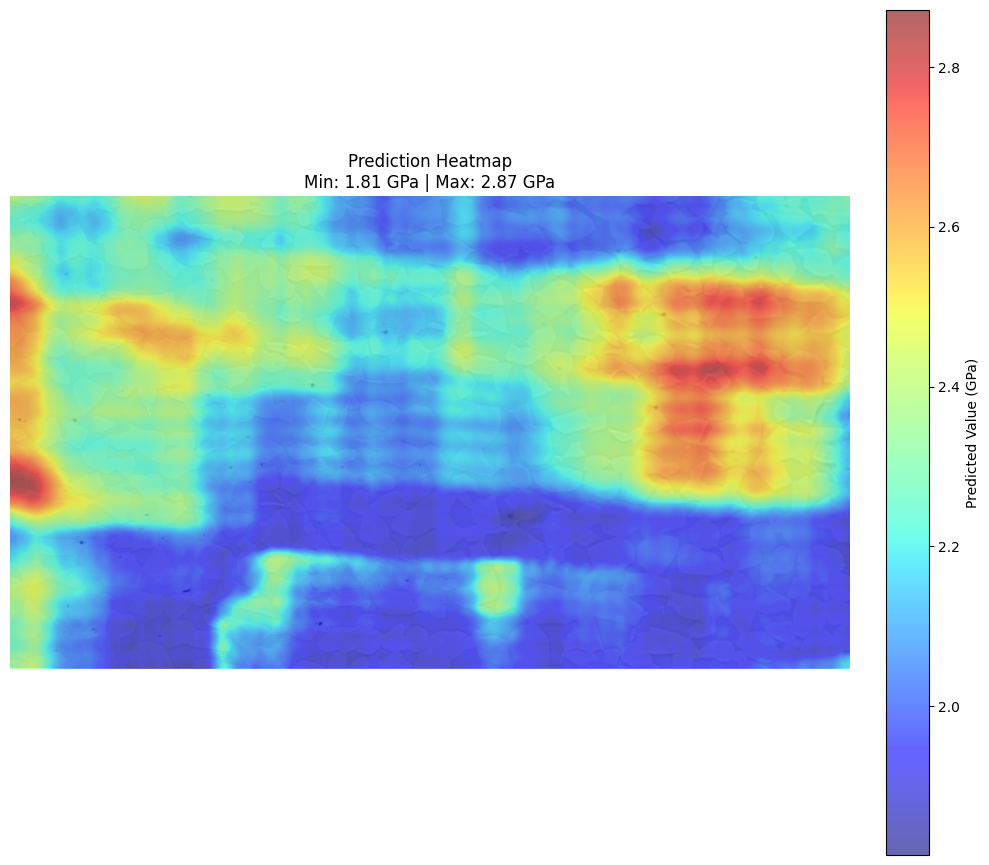

Saved heatmap only to: final_heatmap.png


In [42]:
import torch
from torchvision import transforms

# 1. Define the Transform with ImageNet Stats
# These match exactly what you used during training
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

inference_transform = transforms.Compose([
    # Step A: Resize the small crop (e.g. 64x64) up to Model Size (384x384)
    # We use BICUBIC interpolation to keep the zoomed-in image sharp
    transforms.Resize((384, 384), interpolation=transforms.InterpolationMode.BICUBIC),
    
    # Step B: Convert to Tensor (0-1 range)
    transforms.ToTensor(),
    
    # Step C: Normalize (Shift to match ImageNet distribution)
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# 2. Run the Heatmap Generator
# Ensure 'model_regressor' is loaded and on the correct device
heatmap_grid, img_obj = generate_sliding_window_heatmap(
    model=model_regressor, 
    image_path="Snap-2483.png",   # Your uploaded image
    
    crop_size=(384, 384),           # The window size scanning the image
    stride=8,                    # Overlap (smaller = smoother, 16 is good)
    model_input_size=(384, 384),  # The size the model expects
    
    device=device,
    # transform=inference_transform # <--- Passing the normalized transform here!
)

# 3. Visualize
plot_heatmap_overlay(heatmap_grid, img_obj)

save_heatmap_only(heatmap_grid, img_obj, save_path="final_heatmap.png")